In [1]:
import os

In [2]:
%pwd

'd:\\college_work\\4th year\\Sem7th\\Project\\OBE\\Paper- Blooms taxanomy\\Boolm-s-Level-Detection-A-MLOPS-Project\\research'

In [3]:
os.chdir("../")
%pwd

'd:\\college_work\\4th year\\Sem7th\\Project\\OBE\\Paper- Blooms taxanomy\\Boolm-s-Level-Detection-A-MLOPS-Project'

## Data Cleaning

In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [7]:
df = pd.read_csv("./artifacts/data_ingestion/blooms_dataset.csv")
df

,Text,Level
0,About what proportion of the population of the...,Remember
1,Correctly label the brain lobes indicated on t...,Remember
2,Define compound interest.,Remember
3,Define four types of traceability.,Remember
4,Define mercantilism.,Remember
...,...,...
595,can you devise an explicit formula for,Create
596,Do you devise a systematic approach in order ...,Create
597,Develop and execute a program for this exercise,Create
598,Develop a network based on the following inf...,Create


<Axes: xlabel='Level'>

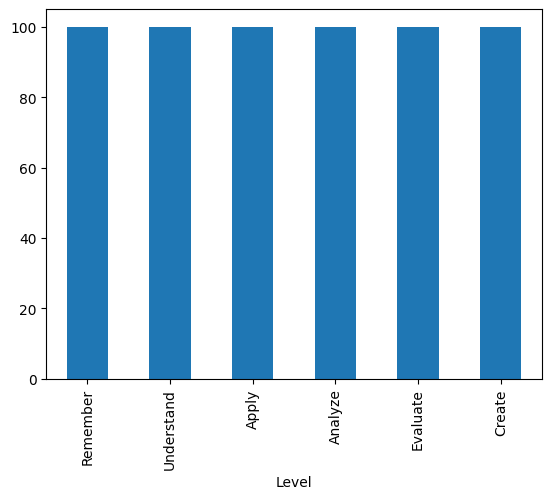

In [8]:
df["Level"].value_counts().plot(kind="bar")

Checking for extra leading and trailing space in sentences

In [9]:
print(f" {df[df['Text'].str.startswith(' ')].shape}")
print(f" {df[df['Text'].str.endswith(' ')].shape}")

df['Text'] = df['Text'].str.strip()

print(f" {df[df['Text'].str.startswith(' ')].shape}")
print(f" {df[df['Text'].str.endswith(' ')].shape}")

 (276, 2)
 (35, 2)
 (0, 2)
 (0, 2)


Creating another dataframe with lower cases 
because uncased data is only used with pretrained model like BERD because they are case sensetive 

In [10]:
bert_df = df
print(f"is lower {df[df['Text'].str.islower()].shape}")
df["Text"] = df["Text"].str.lower()
print(f"is lower {df[df['Text'].str.islower()].shape}")

is lower (22, 2)
is lower (600, 2)


Performing the nltk and berttokenization to show the difference

In [11]:
# from transformers import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# test = "this is an example of ANN"

# tokens = tokenizer(test,return_tensors='pt')
# print(tokens)

In [12]:
from nltk.tokenize import word_tokenize

df["Tokens"] = [word_tokenize(text) for text in df["Text"]]

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', raise_on_error=True,)

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


ValueError: Error loading stopwords: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

In [ ]:
stop_words = set(stopwords.words('english'))


def remove_stop(tokens):
    return [token for token in tokens if token not in stop_words]

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Ukant/nltk_data'
    - 'c:\\Users\\Ukant\\anaconda3\\envs\\blooms\\nltk_data'
    - 'c:\\Users\\Ukant\\anaconda3\\envs\\blooms\\share\\nltk_data'
    - 'c:\\Users\\Ukant\\anaconda3\\envs\\blooms\\lib\\nltk_data'
    - 'C:\\Users\\Ukant\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## MLops steps

In [8]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    clean_data_path: Path

In [9]:
from blooms.constants import *
from blooms.utils.common import read_yaml, create_directories


class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH,
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_tranformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            clean_data_path=config.clean_data_path,
        )
        return data_transformation_config

In [14]:
from sklearn.model_selection import train_test_split
from blooms import logger
import pandas as pd
from nltk.tokenize import word_tokenize



class DataTrnsformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def data_preprocessing(self):
        df = pd.read_csv(self.config.data_path)
        df["Text"] = df["Text"].str.strip()
        df["Text"] = df["Text"].str.lower()
        df['Tokens'] = [word_tokenize(text) for text in df['Text']]
        df = df.sample(frac=1, random_state=1).reset_index(drop=True)
        logger.info(
            f"Done the prerocessing! Saving the cleaned file at: {self.config.clean_data_path}")
        df.to_csv(self.config.clean_data_path)

    def train_test_splitting(self):
        data = pd.read_csv(self.config.clean_data_path)
        train, test = train_test_split(data)

        train.to_csv(os.path.join(
            self.config.root_dir, "train.csv"), index=False)
        test.to_csv(os.path.join(
            self.config.root_dir, "test.csv"), index=False)

        logger.info(f"Splited data into training and testing sets")
        logger.info(train.shape)
        logger.info(test.shape)

In [15]:
try:
    config = ConfigurationManager()
    data_transfermation_config = config.get_data_tranformation_config()
    data_transfermation = DataTrnsformation(config=data_transfermation_config)
    data_transfermation.data_preprocessing()
    data_transfermation.train_test_splitting()
except Exception as e:
    raise e

[2023-12-14 23:45:29: INFO: common: yaml file: config\config.yaml loaded succcessfully]
[2023-12-14 23:45:29: INFO: common: yaml file: params.yaml loaded succcessfully]
[2023-12-14 23:45:29: INFO: common: yaml file: schema.yaml loaded succcessfully]
[2023-12-14 23:45:29: INFO: common: created directory at : artifacts]
[2023-12-14 23:45:29: INFO: common: created directory at : artifacts/data_transformation]
[2023-12-14 23:45:29: INFO: 1262177776: Done the prerocessing! Saving the cleaned file at: artifacts/data_transformation/clean_blooms_dataset.csv]
[2023-12-14 23:45:29: INFO: 1262177776: Splited data into training and testing sets]
[2023-12-14 23:45:29: INFO: 1262177776: (450, 4)]
[2023-12-14 23:45:29: INFO: 1262177776: (150, 4)]
